In [31]:
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import RandomizedLasso, Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from subprocess import check_output


In [4]:
#df = pd.read_csv(r'/home/pirwin/Git/IPy_Notebooks/SQL/CNTYVARS.csv')
df = pd.read_csv(r'C:\Users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\CNTYVARS.csv')
df['HSGRAD_PRCNT'] = df['HSGRAD_CY']/df['TOTPOP_CY']

In [5]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
print(dtype_df[dtype_df['Column Type'] == 'object'])

         Count Column Type
783   TSEGCODE      object
784   TSEGNAME      object
854  TLIFECODE      object
855  TLIFENAME      object


In [6]:
dp = ['OBJECTID','Customers', 'UNITS', 'SALES', 'LOG_UNITS', 'TSEGCODE','TSEGNAME','TLIFECODE','TLIFENAME']

X = df.drop(dp, axis=1)

#X2 = transformer.fit_transform(X, y)

#X2.head()

In [7]:
y = df[['LOG_UNITS']]
y.shape

(3109, 1)

In [8]:
selector = SelectPercentile(f_regression, percentile=20)
columns = X.columns
selector.fit_transform(X, np.array(y))
labels = [columns[x] for x in selector.get_support(indices=True) if x]
XNew = pd.DataFrame(selector.fit_transform(X, np.array(y)), columns = labels)
columns = XNew.columns


lst = list()
for n, s in zip(columns, selector.scores_):
    lst.append((s, n))

scores = pd.DataFrame(lst, columns=['Score','Name'])
    


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [9]:
inds = list()
for val in columns:
    #print(val)
    inds.append((val, XNew.columns.get_loc(val)))
    
indices = pd.DataFrame(inds, columns=['Name','XNew_Index'])
    


In [10]:
scores.sort_values(by='Score',inplace=True, ascending=True)
scores.reset_index(inplace=True)
#scores.to_csv(r'C:\Users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\varscores.csv')
#scores.to_csv(r'/home/pirwin/Git/IPy_Notebooks/SQL/varscores.csv')

In [11]:
scores.drop('index', inplace=True, axis = 1)

df = pd.merge(scores, indices, how='inner',left_on='Name',right_on='Name')



In [12]:
def calculate_vif(X, thresh=7.5):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            # Loop repeatedly until we find that all columns within our dataset
            # have a VIF value we're happy with.
            variables = X.columns
            dropped=False
            vif = []
            new_vif = 0
            for var in variables:
                new_vif = variance_inflation_factor(X.as_matrix(), X.columns.get_loc(var))
                vif.append(new_vif)
                if np.isinf(new_vif):
                    break
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)                
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                #df = df[df['Name'] != str(X.columns[maxloc])]
                dropped=True
        return X

In [17]:
rlasso = RandomizedLasso(alpha=0.001)
rlasso.fit(X, np.ravel(y))

RandomizedLasso(alpha=0.001, eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=500, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

In [18]:
print("Features sorted by their score:")
lassoscored = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 X.columns), reverse=True), columns=['Score','Feature'])
lassoscored = lassoscored[lassoscored['Score'] > 0]
lassolist = lassoscored['Feature'].as_matrix().tolist()
print(lassoscored)

Features sorted by their score:
     Score     Feature
0    0.840  MEDNWA15CY
1    0.760   MEDHHR_CY
2    0.745       THH47
3    0.715    LANDAREA
4    0.700    THHGRPU6
5    0.660   MEDVAL_CY
6    0.595       THH24
7    0.580  UNEMPRT_CY
8    0.570    TADULT58
9    0.520  AVGNWA65CY
10   0.510    THHGRPU5
11   0.480   THHGRPL10
12   0.475       THH48
13   0.470     N40_BUS
14   0.465  AVGNWA35CY
15   0.460  MEDMAGE_CY
16   0.455  POPGRW10CY
17   0.430  AVGNWA55CY
18   0.410  AVGNWA45CY
19   0.360       THH58
20   0.350       THH22
21   0.300    THHGRPL6
22   0.290       THH25
23   0.290    TADULT47
24   0.290    TADULT18
25   0.275       THH18
26   0.275    TADULT15
27   0.270       THH50
28   0.270       THH13
29   0.270    TADULT25
..     ...         ...
124  0.010    BLACK_CY
125  0.010  AMERIND_CY
126  0.010  A75NW150CY
127  0.005     TSEGNUM
128  0.005    THHGRPU3
129  0.005    THHGRPL3
130  0.005    THHGRPL1
131  0.005       THH68
132  0.005       THH55
133  0.005       THH54
13

In [19]:
XNew2 = X[lassolist]

In [20]:
XNew2.head()

,MEDNWA15CY,MEDHHR_CY,THH47,LANDAREA,THHGRPU6,MEDVAL_CY,THH24,UNEMPRT_CY,TADULT58,AVGNWA65CY,...,TADULT36,TADULT35,TADULT28,NONHISP_CY,N05_BUS,INDAGRI_CY,BAGEBASECY,A75I25_CY,A75DI75_CY,A65DI35_CY
0,10426,50.3,0,739.0174,856,590884,0,6.4,2288,1307236,...,10453,2784,88045,1235121,4608,2664,178239,5782,3850,9266
1,13472,60.4,0,594.5831,7783,284436,0,8.0,872,1551087,...,0,0,0,33429,224,247,960,476,145,576
2,8933,53.5,1609,1636.4644,9415,259717,830,8.7,2415,988540,...,0,11222,1791,190565,1009,3112,3741,1827,468,2436
3,15574,59.9,0,1020.0123,10535,256835,0,5.3,1442,1600593,...,0,0,0,39615,287,476,444,485,151,639
4,11583,52.1,0,1150.7310,1744,214455,594,7.0,539,767654,...,0,0,1666,9040,58,2715,231,150,37,175


In [21]:
lassofinal = calculate_vif(XNew2, thresh=5)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping THH47 with vif=inf
Dropping THHGRPU6 with vif=inf
Dropping THH24 with vif=inf
Dropping S24_BUS with vif=inf
Dropping S11_EMP with vif=inf
Dropping BLACK_CY with vif=inf
Dropping N40_BUS with vif=249956.93445079145
Dropping N40_EMP with vif=181107.2590033939
Dropping MEDAGE_CY with vif=62411.48388113689
Dropping TADULT61 with vif=10925.249607113574
Dropping THHGRPL6 with vif=10896.638331430275
Dropping BLKMBASECY with vif=10637.673338929428
Dropping TADULT51 with vif=9628.520061756653
Dropping THH36 with vif=4293.456550608163
Dropping AREA with vif=4124.626696966668
Dropping AMERIND_CY with vif=3099.7997397130553
Dropping MEDIA55UCY with vif=3045.665284338253
Dropping TADULT04 with vif=2231.3179521773995
Dropping THH18 with vif=1994.0392973217167
Dropping MEDIA65_CY with vif=1811.9251827336543
Dropping THHGRPL10 with vif=1798.2632005718308
Dropping THH02 with vif=1689.6175265667955
Dropping THH40 with vif=1525.5677068093357
Dropping MEDFAGE_CY with vif=1426.5551013905217
Droppi

In [22]:
lassofinal.head()

,LANDAREA,UNEMPRT_CY,TADULT58,THH48,TADULT47,TADULT18,TADULT15,THH50,THH13,TADULT25,...,OCCFARM_CY,THHGRPL3,THH68,THH55,THH49,THH37,TADULT57,TADULT54,TADULT36,TADULT35
0,739.0174,6.4,2288,0,0,0,0,0,4102,0,...,1854,78075,11,4429,1077,3177,1124,7115,10453,2784
1,594.5831,8.0,872,0,0,0,0,0,0,4262,...,36,0,0,0,0,0,0,0,0,0
2,1636.4644,8.7,2415,334,3596,1611,0,908,0,975,...,1723,0,0,0,876,1125,662,7721,0,11222
3,1020.0123,5.3,1442,0,0,0,0,0,0,3577,...,145,0,0,0,0,0,0,0,0,0
4,1150.7310,7.0,539,0,0,0,1601,0,0,0,...,1652,0,0,0,0,253,0,0,0,0


In [23]:
import statsmodels.api as sts


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [24]:
XNew3 = sts.add_constant(lassofinal)
mod = sts.OLS(y, XNew3)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              LOG_UNITS   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     100.4
Date:                Fri, 08 Sep 2017   Prob (F-statistic):               0.00
Time:                        14:17:37   Log-Likelihood:                -4131.8
No. Observations:                3109   AIC:                             8350.
Df Residuals:                    3066   BIC:                             8609.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8342      0.068     86.323      0.0

In [65]:
var = ['const','TADULT24','TADULT26','TADULT42','THH61','UNEMPRT_CY','THH13','TADULT43','TADULT41',
       'LANDAREA','TADULT58','THH48','TADULT47','TADULT18','TADULT15','THH50','TADULT25','N04_SALES','TADULT22',
       'TADULT17','THH46','THH21','FAMGRW10CY','THH23','TADULT30','OCCFARM_CY']
XNew4 = XNew3[var]

In [66]:
mod = sts.OLS(y, XNew4)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              LOG_UNITS   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     162.8
Date:                Fri, 08 Sep 2017   Prob (F-statistic):               0.00
Time:                        15:36:43   Log-Likelihood:                -4168.4
No. Observations:                3109   AIC:                             8389.
Df Residuals:                    3083   BIC:                             8546.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8005      0.050    116.546      0.0

In [27]:
%matplotlib inline

In [67]:
cm = np.corrcoef(XNew4.values.T)
sns.set(font_scale=1)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


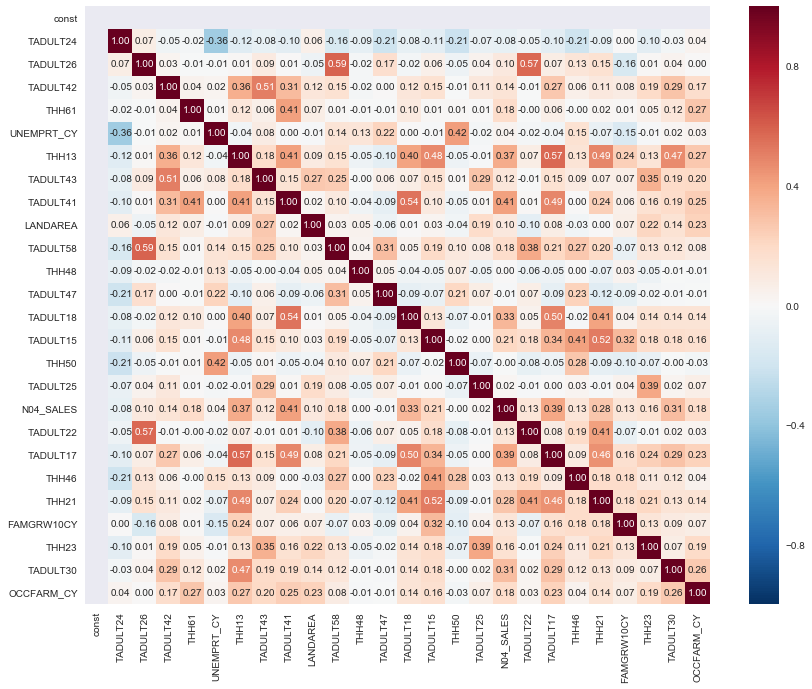

In [68]:
cols = XNew4.columns.values
cols2 = cols.tolist()
fig, ax = plt.subplots(figsize = (14, 11))
hm = sns.heatmap(cm, 
                 cbar=True, 
                 annot=True,
                 #square=True,
                 fmt='.2f',
                 annot_kws={'size':10},
                 yticklabels=cols2,
                 xticklabels=cols2,
                 )
plt.show()
fig.savefig('corrplot.png')


In [64]:
XNew4.corr()

,const,TADULT24,HISPBLK_CY,TADULT26,THH37,TADULT42,THH61,UNEMPRT_CY,THH13,TADULT43,...,TADULT02,N04_SALES,TADULT22,TADULT17,THH46,THH21,FAMGRW10CY,THH23,TADULT30,OCCFARM_CY
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TADULT24,NaN,1.000000,-0.076556,0.070899,-0.076856,-0.046831,-0.019831,-0.356830,-0.121784,-0.079308,...,-0.108354,-0.084838,-0.051893,-0.103711,-0.206419,-0.090158,0.000537,-0.103929,-0.026252,0.037486
HISPBLK_CY,NaN,-0.076556,1.000000,-0.001528,0.309134,0.185698,0.334538,0.033198,0.313271,0.115681,...,0.288767,0.350707,0.005941,0.241033,0.032448,0.115226,0.067068,0.065531,0.255612,0.209004
TADULT26,NaN,0.070899,-0.001528,1.000000,-0.029676,0.026446,-0.005939,-0.005236,0.013882,0.090830,...,-0.011312,0.104854,0.570694,0.073652,0.125538,0.151174,-0.159727,0.007957,0.036932,0.003980
THH37,NaN,-0.076856,0.309134,-0.029676,1.000000,0.204837,0.122335,0.032527,0.448214,0.150271,...,0.338862,0.409201,0.031614,0.527358,0.030213,0.384146,0.085141,0.219713,0.223470,0.277001
TADULT42,NaN,-0.046831,0.185698,0.026446,0.204837,1.000000,0.042557,0.024770,0.364421,0.509202,...,0.249847,0.135495,-0.005649,0.270696,0.062237,0.106517,0.080229,0.187571,0.288028,0.173238
THH61,NaN,-0.019831,0.334538,-0.005939,0.122335,0.042557,1.000000,0.007977,0.124904,0.056903,...,0.151572,0.180620,-0.002404,0.063673,-0.003019,0.021638,0.008578,0.051967,0.117793,0.274805
UNEMPRT_CY,NaN,-0.356830,0.033198,-0.005236,0.032527,0.024770,0.007977,1.000000,-0.037196,0.081946,...,-0.048382,0.039001,-0.015748,-0.036237,0.152918,-0.074927,-0.151561,-0.012658,0.018164,0.032534
THH13,NaN,-0.121784,0.313271,0.013882,0.448214,0.364421,0.124904,-0.037196,1.000000,0.184447,...,0.650311,0.371597,0.074508,0.573722,0.132985,0.491435,0.240510,0.134631,0.469766,0.272499
TADULT43,NaN,-0.079308,0.115681,0.090830,0.150271,0.509202,0.056903,0.081946,0.184447,1.000000,...,0.079718,0.121886,-0.006069,0.149526,0.087424,0.068460,0.069216,0.351671,0.190087,0.198786
